In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scienceplots
import matplotlib as mpl
import sys
# sys.path.append("/home/jonas/phd/pytools/")
sys.path.append("/mnt/c/Users/jonas/Desktop/phd/pytools/")
import npnet.tools as nptools
import npnet.graph as npgraph

gates   = ['AND','OR','XOR','NAND','NOR','XNOR']
markers = ['o', 's', 'p', 'v', '^', '<', '>', 'x','o', 's', 'p', 'v', '^', '<', '>', 'x']
lss     = ['solid','dotted','dashed','dashdot','solid','dotted','dashed','dashdot']


In [ ]:
dic     = {}
dic_b   = {}
dic_nc  = {}
boot    = True
M_steps = 20
df          = pd.read_csv("Nx=3_Ny=3_Nz=1_Ne=8.csv")
df.columns  = ['C1','C2','I1','C3','I2','C4','C5','O','G','Jumps_eq','Jumps','Current','Error']
df          = df[['I1','I2','C1','C2','C3','C4','C5','G','Jumps','Current','Error']]
dic_b[3]    = df
df1         = df.copy()
df1         = df1[df1['Error'] != 0].reset_index(drop=True)
df1         = df1.sort_values(by=['C1','G','I1','I2'], ignore_index=True)
df1         = nptools.prepare_for_fitness_calculation(df=df1, min_current=0.0, N_c=5)

df2         = df[~df['G'].isin(df1['G'])]
df2         = df2.sort_values(by=['C1','G','I1','I2'], ignore_index=True)

if boot == True:
    dic[3]      = nptools.vary_currents_by_error(df=df1, M=M_steps)
    dic_nc[3]   = nptools.vary_currents_by_error(df=df2, M=M_steps)
else:
    dic[3]      = df1
    dic_nc[3]   = df2

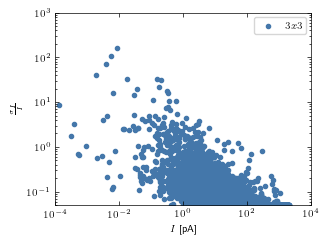

In [13]:
with plt.style.context(["science","nature","bright"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    N   = 10

    for N in [3]:

        df  = dic_b[N].copy()
        ax.scatter(df['Current'].abs(), (df['Error']/df['Current']).abs(),label=f'${N}x{N}$')

    ax.set_xlim(0.0001,10000)
    ax.set_ylim(0.05,1000)
    ax.legend(loc='upper right', frameon=True)
    ax.set_xlabel("$I$ [pA]")
    ax.set_ylabel("$\\frac{\sigma_I}{I}$")
    ax.set_xscale('log')
    ax.set_yscale('log')
    # fig.savefig("plots/error_scatter.svg", bbox_inches='tight', transparent=True)
    # fig.savefig("plots/error_scatter.pdf", bbox_inches='tight', transparent=False)
plt.show()

In [27]:
dic_f       = {}
dic_f_nc    = {}

for key in dic.keys():

    df1             = nptools.fitness(df=dic[key], N_controls=5, error_column=None)
    df2             = dic_nc[key].drop(columns=['I1','I2','Current'])[::4].reset_index(drop=True)
    for gate in gates:
        df2[gate+' Fitness'] = -100000
    dic_f[key]      = df1
    dic_f_nc[key]   = df2

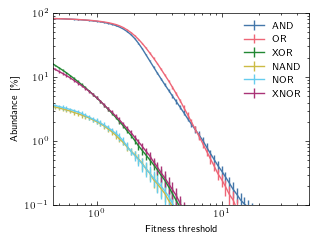

In [34]:
xrange  = np.logspace(-1,2,100)

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots()

    for i, key in enumerate(dic.keys()):

        for gate in gates:
        
            df          = dic_f[key]
            df          = pd.concat([df,dic_f_nc[key]], ignore_index=True)
            ymean, ystd = nptools.boot_abundance(df=df, xrange=xrange, gate=gate)
            
            ax.errorbar(x=xrange, y=ymean, yerr=ystd, label=gate)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.1,100)
    ax.set_xlim(0.45,50)
    ax.legend()

    ax.set_ylabel("Abundance [\%]")

    ax.set_xlabel("Fitness threshold")


    # fig.savefig("plots/abundance_vs_size.svg", bbox_inches='tight', transparent=True)
    # fig.savefig("plots/abundance_vs_size.pdf", bbox_inches='tight', transparent=False)
    
plt.show()

In [ ]:
def n_junctions(N):

    return 2*N*2*(N-1)

def sigma_N_rel(N, N0, sN, sN0):

    return np.sqrt((sN/N0)**2 + (sN0*N/(N0**2))**2)

F_th   = 5

with plt.style.context(["science","nature","bright","grid"]):

    fig = plt.figure()
    ax  = fig.add_subplot()

    for nth, gate in enumerate(gates):
        
        means   = []
        stds    = []
        
        for key in dic_f.keys():

            df      = dic_f[key]
            df      = pd.concat([df,dic_f_nc[key]],ignore_index=True)
            n_nl    = []
            
            for resample in range(M_steps):

                df_sample   = df.sample(n=len(df), replace=True, ignore_index=True)
                n_nl.append((df_sample[gate+' Fitness'] > F_th).sum()/len(df_sample))

            means.append(np.mean(n_nl))
            stds.append(np.std(n_nl))
        
        means   = np.array(means)
        stds    = np.array(stds)*np.sqrt(M_steps)
        N0      = means[0]
        sN0     = stds[0]
        
        for i in range(0,len(means)):

            stds[i]     = sigma_N_rel(means[i], N0, stds[i], sN0) 
            means[i]    = means[i]/N0

        df_reg      = pd.DataFrame()
        df_reg['0'] = np.array(list(dic_f.keys()))**2
        df_reg['1'] = means
        df_reg['2'] = stds

        p   = ax.errorbar(x=df_reg['0'].values, y=means, yerr=stds, capsize=2, marker=markers[nth], ls='', label=gate)
        ax  = sns.regplot(x='0', y='1', data=df_reg, ax=ax, order=1, logx=False, ci=None, marker='', color=p[0].get_color())

    ax.legend(ncol=2,fontsize='small')
    ax.set_xlabel("$N_{NP}$")

    ax.set_ylabel(f'I\kern-0.15em P$[F > {F_th}]'+f'/$I\kern-0.15em P$[F > {F_th}'+'|N_{NP} = 9]$')
    fig.savefig(f"plots/n_gates_rel_Fth={F_th}.svg",bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/n_gates_rel_Fth={F_th}.pdf",bbox_inches='tight', transparent=False)

plt.show()

Coulomb Blockade

In [ ]:
transition_array    = pd.read_csv(f"../../../data/system_size/transition_array/Nx={3}_Ny={3}_Nz=1_Ni=0_No=1_Nc=7.csv",header=None)
transition_array    = transition_array.iloc[:,[1,2]]
transition_array    = transition_array.replace(to_replace=-23, value=-1)
transition_array    = transition_array.replace(to_replace=-24, value=-23)
transition_array    = transition_array.replace(to_replace=-25, value=-2)
transition_array    = transition_array.replace(to_replace=-26, value=-24)
transition_array    = transition_array.replace(to_replace=-27, value=-25)

G                   = npgraph.get_graph_objects(transition_arr=transition_array, N_p=3*3, N_i=2, N_o=1, N_c=5)
pos                 = npgraph.get_graph_position(G)

fig = plt.figure()
ax  = fig.add_subplot()
ax  = npgraph.draw_graph(ax=ax, graph_obj=G, pos=pos, N_i=2, N_o=1, N_c=5, font_size_node=26, node_size=100, arrows=False)
plt.show()


In [ ]:
ax.get_legend_handles_labels()[0]

In [ ]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

N       = 3
U       = dic_f[N].loc[:,'C1'].values
Ug      = dic_f[N].loc[:,'G'].values
U_nc    = dic_f_nc[N].loc[:,'C1'].values
Ug_nc   = dic_f_nc[N].loc[:,'G'].values

for N in range(4,11):
    U       = np.concatenate((U, dic_f[N].loc[:,'C1'].values))
    Ug      = np.concatenate((Ug, dic_f[N].loc[:,'G'].values))
    U_nc    = np.concatenate((U_nc, dic_f_nc[N].loc[:,'C1'].values))
    Ug_nc   = np.concatenate((Ug_nc, dic_f_nc[N].loc[:,'G'].values))

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots()
    ax      = sns.histplot(1000*U.flatten(), bins=20,ax=ax,stat='density',legend=False, label='a',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=blue_color)
    ax      = sns.histplot(1000*U_nc.flatten(), bins=20,ax=ax,stat='density',alpha=.8, legend=False, label='b',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=red_color)
    ax.legend([ax.get_legend_handles_labels()[0][0],
            ax.get_legend_handles_labels()[0][1]],
            ['$\{I | I \\neq 0 \land \sigma_I \\neq 0\}$','$\{I | I = 0 \lor \sigma_I = 0\}$'],frameon=True)
    ax.set_xlabel("$U_{C"+f"{i}"+"}$ [mV]")
    ax.set_xlim(-50,50)
    fig.savefig(f"plots/voltages/coulomb_block_U_1.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/voltages/coulomb_block_U_1.pdf", bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

N       = 3
U       = dic_f[N].loc[:,['C2','C3']].values
Ug      = dic_f[N].loc[:,'G'].values
U_nc    = dic_f_nc[N].loc[:,['C2','C3']].values
Ug_nc   = dic_f_nc[N].loc[:,'G'].values

for N in range(4,11):
    U       = np.concatenate((U, dic_f[N].loc[:,['C2','C3']].values))
    Ug      = np.concatenate((Ug, dic_f[N].loc[:,'G'].values))
    U_nc    = np.concatenate((U_nc, dic_f_nc[N].loc[:,['C2','C3']].values))
    Ug_nc   = np.concatenate((Ug_nc, dic_f_nc[N].loc[:,'G'].values))

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots()
    ax      = sns.histplot(1000*U.flatten(), bins=20,ax=ax,stat='density',legend=False, label='a',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=blue_color)
    ax      = sns.histplot(1000*U_nc.flatten(), bins=20,ax=ax,stat='density',alpha=.8, legend=False, label='b',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=red_color)
    ax.legend([ax.get_legend_handles_labels()[0][0],
            ax.get_legend_handles_labels()[0][1]],
            ['$\{I | I \\neq 0 \land \sigma_I \\neq 0\}$','$\{I | I = 0 \lor \sigma_I = 0\}$'],frameon=True)
    ax.set_xlabel("$U_{C"+f"{i}"+"}$ [mV]")
    ax.set_xlim(-50,50)
    fig.savefig(f"plots/voltages/coulomb_block_U_23.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/voltages/coulomb_block_U_23.pdf", bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
blue_color          = '#4477AA'
red_color           = '#EE6677'

N       = 3
U       = dic_f[N].loc[:,['C4','C5']].values
Ug      = dic_f[N].loc[:,'G'].values
U_nc    = dic_f_nc[N].loc[:,['C4','C5']].values
Ug_nc   = dic_f_nc[N].loc[:,'G'].values

for N in range(4,11):
    U       = np.concatenate((U, dic_f[N].loc[:,['C4','C5']].values))
    Ug      = np.concatenate((Ug, dic_f[N].loc[:,'G'].values))
    U_nc    = np.concatenate((U_nc, dic_f_nc[N].loc[:,['C4','C5']].values))
    Ug_nc   = np.concatenate((Ug_nc, dic_f_nc[N].loc[:,'G'].values))

with plt.style.context(["science","nature","bright"]):

    fig, ax = plt.subplots()
    ax      = sns.histplot(1000*U.flatten(), bins=20,ax=ax,stat='density',legend=False, label='a',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=blue_color)
    ax      = sns.histplot(1000*U_nc.flatten(), bins=20,ax=ax,stat='density',alpha=.8, legend=False, label='b',kde=False,line_kws={'lw':2},kde_kws={"bw_adjust":2}, color=red_color)
    ax.legend([ax.get_legend_handles_labels()[0][0],
            ax.get_legend_handles_labels()[0][1]],
            ['$\{I | I \\neq 0 \land \sigma_I \\neq 0\}$','$\{I | I = 0 \lor \sigma_I = 0\}$'],frameon=True)
    ax.set_xlabel("$U_{C"+f"{i}"+"}$ [mV]")
    ax.set_xlim(-50,50)
    fig.savefig(f"plots/voltages/coulomb_block_U_45.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/voltages/coulomb_block_U_45.pdf", bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
def lin_curve(x,m,a,b):
    return m*(x-a) + b

xvals   = []
yvals   = []
xnews   = np.linspace(9,144,100)

for key in dic.keys():

    xvals.append(key*key)
    yvals.append(len(dic_nc[key])/(len(dic[key])+len(dic_nc[key])))

p, cov = curve_fit(lin_curve, xvals, yvals)

with plt.style.context(["science", "nature", "bright"]):

    fig, ax = plt.subplots()
    ax.plot(xvals, 100*np.array(yvals), 'o')
    ax.plot(xnews, 100*lin_curve(xnews,*p))
    ax.set_xlabel("$N_{NP}$")
    
    ax.set_ylabel('I\kern-0.15em P$(I \\neq 0 \cap \sigma_I \\neq 0)$ [\%]')
    fig.savefig(f"plots/coulomb_block_prob.svg", bbox_inches='tight', transparent=True)
    fig.savefig(f"plots/coulomb_block_prob.pdf", bbox_inches='tight', transparent=False)
plt.show()

Network Plots

In [ ]:
def get_symmetrical_pos(Nx : int, Ny : int) -> dict:

    pos = {}
    x   = 0
    y   = 0
    ind = 0

    while (ind < (Nx*Ny)):

        pos[ind]    = (x, y)
        x           += 1

        if ((x % Nx) == 0):

            y += 1
            x = 0
        
        if (y == Ny):
            break

        ind += 1

    pos[-11]    = (pos[(Nx*Ny)-1][0] + 1, pos[(Nx*Ny)-1][1] + 1)
    pos[-1]     = (pos[Nx-1][0] + 1, pos[Nx-1][1] - 1)
    pos[-2]     = (pos[(Nx*Ny)-Nx][0] - 1, pos[(Nx*Ny)-Nx][1] + 1)
    pos[-21]    = (pos[0][0] - 1, pos[0][1] - 1)

    pos[-23]    = (pos[int(np.ceil(Nx/2))*Nx - 1][0] + 1, pos[int(np.ceil(Nx/2))*Nx - 1][1])
    pos[-25]    = (pos[-23][1], pos[-23][0])

    # pos[-23]    = (pos[(Nx*Ny) - int(np.ceil(Nx/2))][0], pos[(Nx*Ny) - int(np.ceil(Nx/2))][1]+1)
    pos[-22]    = (pos[int(np.floor((Nx-1)/2))][0], -1)
    pos[-24]    = (pos[-22][1], pos[-22][0])

    return pos

In [ ]:
graphs      = {}
transitions = {}         
fig         = plt.figure()
fig.set_figwidth(fig.get_figwidth()*1.5)
fig.set_figheight(fig.get_figheight()*0.75)

for i,N in enumerate([3,4,5,6,7,8,9,10,11,12]):

    ax                  = fig.add_subplot(2,5,i+1)
    try:
        t_arr               = pd.read_csv(f"../../../data/system_size/transition_array/Nx={N}_Ny={N}_Nz=1_Ni=0_No=1_Nc=7.csv",header=None)
        t_arr               = t_arr.replace(to_replace=-23,value=-1)
        t_arr               = t_arr.replace(to_replace=-25,value=-2)
        t_arr               = t_arr.replace(to_replace=-26,value=-23)
        t_arr               = t_arr.replace(to_replace=-27,value=-25)
        transitions[N]      = t_arr
        transition_array    = transitions[N].iloc[:,[1,2]]
        G                   = npgraph.get_graph_objects(transition_arr=transition_array, N_p=N*N, N_i=2, N_o=1, N_c=5)
        pos                 = get_symmetrical_pos(N,N)
        sizes               = np.repeat(20,len(list(G)))
        colors              = np.repeat('#004d99', len(list(G)))
        ax                  = npgraph.draw_graph(ax=ax, graph_obj=G, pos=pos, N_i=2, N_o=1, N_c=5, font_size_node=12,
                                node_size=sizes, arrows=False,node_color=colors)
        graphs[N]           = G

    except:
        pass

    fig.savefig(f"plots/system_size_graphs.svg",bbox_inches='tight',transparent=True)
    fig.savefig(f"plots/system_size_graphs.pdf",bbox_inches='tight',transparent=False)
plt.show()

In [ ]:
df  = dic_f[5].copy()
df2 = dic[5].copy()

with plt.style.context(["science","nature","bright"]):

    fig, axes = plt.subplots(nrows=2, ncols=3)
    fig.set_figwidth(fig.get_figwidth()*3)
    fig.set_figheight(fig.get_figheight()*2)
    
    for i, ax in enumerate(axes.flat):
        
        c1  = df[df[gates[i]+' Fitness'] > 10].reset_index(drop=True).loc[0,'C1']
        dfs = df2[df2['C1'].round(6) == np.round(c1,6)]

        try:
            ax.errorbar(x=np.array(['$I_{00}$','$I_{01}$','$I_{10}$','$I_{11}$']), y=dfs['Current'].values, yerr=None, marker='o', ms=5)
        except:
            pass
    
        ax.legend(title=gates[i])

        if ((i == 0) or (i == 3)):
            ax.set_ylabel("Current [pA]")
        else:
            ax.set_ylabel("")
        if i > 2:        
            ax.set_xlabel("Input States")
        else:
            ax.set_xlabel("")
            ax.set_xticklabels([])

    fig.savefig("plots/gate_currents.svg", bbox_inches='tight', transparent=True)
    fig.savefig("plots/gate_currents.pdf", bbox_inches='tight', transparent=False)

IQ Measurement

In [ ]:
def measure_iq(df_sample : pd.DataFrame, F_th : float)->float:
    
    n_gates = []
    
    for gate in gates:

        n_gates.append((df_sample[gate+' Fitness'] > F_th).sum())
    
    N_funcs     = len(gates)
    N_data      = np.log2(len(df_sample))
    gate_logs   = np.log2(np.array(n_gates))

    return (np.sum(gate_logs)-N_data)/(N_funcs)

In [ ]:
F_th    = 2
regplot = False

with plt.style.context(["science","nature","bright"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    
    means   = []
    stds    = []
    
    for key in dic_f.keys():

        df      = dic_f[key]
        df      = pd.concat([df,dic_f_nc[key]],ignore_index=True)
        n_nl    = []
        
        for resample in range(20):

            df_sample   = df.sample(n=len(df), replace=True, ignore_index=True)
            n_nl.append(measure_iq(df_sample, F_th))

        means.append(np.mean(n_nl))
        stds.append(np.std(n_nl))
    
    means   = np.array(means)
    stds    = np.array(stds)*np.sqrt(20)
    
    if regplot == True:

        df_reg      = pd.DataFrame()
        df_reg['0'] = np.array(list(dic_f.keys()))**2
        df_reg['1'] = means
        df_reg['2'] = stds
        ax          = sns.regplot(x='0', y='1', data=df_reg, ax=ax, order=2, logistic=False, ci=None)

    else:
        ax.errorbar(x=np.array(list(dic_f.keys()))**2, y=means, yerr=stds, capsize=2, marker=markers[0])

    ax.set_xlabel("$N_{NP}$")
    ax.set_ylabel('$\\frac{\log_2(\prod_{Gate}[N(F_{Gate}) > 2]) - \log_2(N)}{N_{Gates}}$')
    # fig.savefig(f"plots/boot/iq_Fth={F_th}.svg",bbox_inches='tight', transparent=True)
    # fig.savefig(f"plots/boot/iq_Fth={F_th}.pdf",bbox_inches='tight', transparent=False)

plt.show()

In [ ]:
# xor_vs_and  = []
# xor_vs_ands = []
# F_th        = 5

# with plt.style.context(["science","nature","bright"]):

#     fig = plt.figure()
#     ax  = fig.add_subplot()

#     for key in dic_f.keys():

#         df      = dic_f[key]
#         n_nl    = []
        
#         for resample in range(20):

#             df_sample   = df.sample(n=len(df), replace=True, ignore_index=True)
#             n_nl.append((df_sample['XOR Fitness'] > F_th).sum()/(df_sample['AND Fitness'] > F_th).sum())

#         xor_vs_and.append(np.mean(n_nl))
#         xor_vs_ands.append(np.std(n_nl))

#     ax.errorbar(x=np.array(list(dic_f.keys()))**2, y=np.array(xor_vs_and), yerr=np.array(xor_vs_ands), capsize=2)
#     ax.set_xlabel("$N_{NP}$")
#     ax.set_ylabel(f'I\kern-0.15em P$[F > {F_th}]'+f'/$I\kern-0.15em P$[F > {F_th}'+'|N_{NP} = 9]$')
#     # ax.set_ylabel("$N_{XOR > "+f"{F_th}"+"} / N_{AND > "+f"{F_th}"+"}$")
#     # fig.savefig("plots/boot/xor_and_rel.svg",bbox_inches='tight', transparent=True)
#     # fig.savefig("plots/boot/xor_and_rel.pdf",bbox_inches='tight', transparent=False)
# plt.show()

 Current Correlations

In [ ]:
dic     = {}

for N in range(3,11):

    df      = pd.read_csv(f"../../../data/system_size/Nx={N}_Ny={N}_Nz=1_Ni=0_No=1_Nc=7.csv")
    df      = df.rename(columns={'C3':'I1','C6':'I2','C7':'C3'})
    df      = df[['I1','I2','C1','C2','C3','C4','C5','G','Jumps_eq','Jumps','Current','Error']]
    df      = df[df['Jumps'] > 100]
    df      = df.sort_values(by=['C1','C2','C3','C4','C5','G','I1','I2'],ignore_index=True)
    df      = nptools.prepare_for_fitness_calculation(df=df, min_current=0.00, N_c=5)
    dic[N]  = df

In [ ]:
with plt.style.context(["science",'nature','bright','grid']):

    fig = plt.figure(figsize=(3.3*2.5,2.5))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for i,N in enumerate(range(3,11)):

        df      = dic[N]
        df00    = df[(df['I1']==0.0) & (df['I2']==0.0)]
        df11    = df[(df['I1']==0.01) & (df['I2']==0.01)]

        df10    = df[(df['I1']==0.01) & (df['I2']==0.0)]
        df01    = df[(df['I1']==0.0) & (df['I2']==0.01)]

        ax1.scatter(df00['Current'],df11['Current'], label='$N_{NP} = '+f'{N*N}$',marker=markers[i])
        ax2.scatter(df01['Current'],df10['Current'], label='$N_{NP} = '+f'{N*N}$',marker=markers[i])

    ax1.legend(ncol=2, fontsize='small')
    ax1.set_ylim(-2000,2000)
    ax1.set_xlim(-2000,2000)
    ax1.set_xlabel("$I_{00}$ [pA]")
    ax1.set_ylabel("$I_{11}$ [pA]")

    ax2.set_ylim(-2000,2000)
    ax2.set_xlim(-2000,2000)
    ax2.set_xlabel("$I_{10}$ [pA]")
    ax2.set_ylabel("$I_{01}$ [pA]")

    fig.savefig(f"plots/boot/I00vsI11.svg",bbox_inches='tight',transparent=True)
    fig.savefig(f"plots/boot/I00vsI11.pdf",bbox_inches='tight',transparent=False)
    plt.show()


Return Maxima

In [ ]:
df          = dic_f[7][dic_f[7]['Jumps'] != 10000001.0]
xor_maxima  = df[df['XOR Fitness'] > 3].sample(10).reset_index(drop=True)[['I1','I2','C1','C2','C3','C4','C5','G']].rename(columns={'C3':'C7','I2':'C6','I1':'C3'})
and_maxima  = df[df['AND Fitness'] > 10].sample(10).reset_index(drop=True)[['I1','I2','C1','C2','C3','C4','C5','G']].rename(columns={'C3':'C7','I2':'C6','I1':'C3'})

xor_maxima  = xor_maxima[['C1','C2','C3','C4','C5','C6','C7','G']]
and_maxima  = and_maxima[['C1','C2','C3','C4','C5','C6','C7','G']]

xor_maxima.to_csv("../../../np_network/python/main/data/7_7_xor_values.csv")
and_maxima.to_csv("../../../np_network/python/main/data/7_7_and_values.csv")

In [ ]:
df[df['AND Fitness'] > 10]